In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import sys
sys.path.append('../') # add the root folder to the path

from diffusion_model.backward_module import BackwardModule
from diffusion_model.forward_module import ForwardModule
from diffusion_model.scheduler import Scheduler
from diffusion_model.models import UNetNoiseModel
from diffusion_model.datasets import get_mnist_dataset
from diffusion_model.constants import device

from torch.utils.data import DataLoader

from einops import rearrange

import matplotlib.pyplot as plt
import matplotlib

In [59]:
FIG_SIZE = 4
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

# Datasets

Dataset shape: torch.Size([60000, 28, 28])


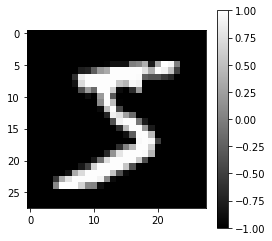

In [60]:
dataset = get_mnist_dataset()
dim = tuple(dataset[0].shape)

plt.imshow(dataset[0].cpu(), cmap='gray')
plt.colorbar();
print(f'Dataset shape: {dataset.shape}')

In [27]:
print(f"Using device: {device}")

Using device: cuda


# Plot helpers

In [28]:
def plot_evolutions(xs_t, y_title=None, title=None):
    fig, axes = plt.subplots(1, len(xs_t), figsize=(FIG_SIZE*len(xs_t), FIG_SIZE))
    if title is not None:
        fig.suptitle(title)
    if y_title is not None:
        axes[0].set_ylabel(y_title)
    for i, ax in enumerate(axes):
        progress = i / (len(xs_t)-1)
        ax.imshow(xs_t[i].cpu(), cmap='gray')
        ax.set_title(f"{progress*100:.0f}%")
    plt.show()

# Diffusion model

In [44]:
T = 10

scheduler = Scheduler(input_dim=dim, nb_steps=T)
forward_module = ForwardModule(scheduler=scheduler)
noise_model = UNetNoiseModel(forward_module=forward_module, scheduler=scheduler)
backward_module = BackwardModule(forward_module=forward_module, scheduler=scheduler, noise_model=noise_model)

## Forward

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


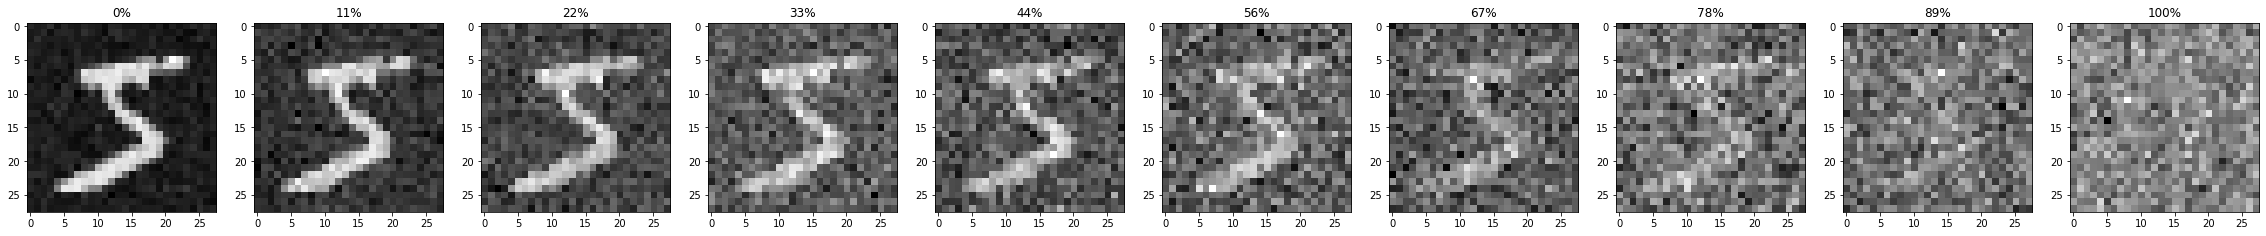

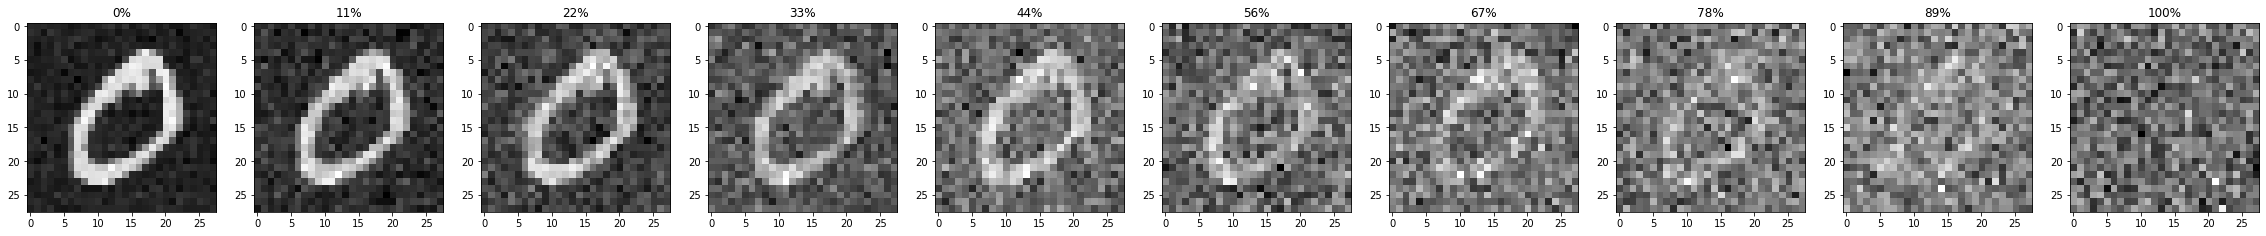

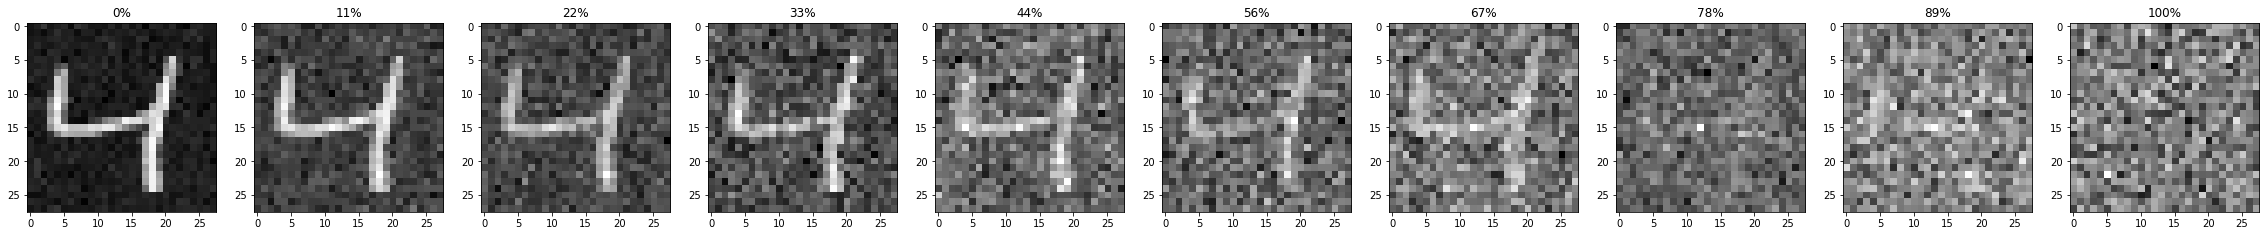

In [46]:
NB_DISPLAYED = 10
NB_EXAMPLES = 3

xs = dataset[:NB_EXAMPLES]
xs = forward_module.loop_forward(xs, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for x in xs:
    plot_evolutions(x)

## Train the noise model

  0%|                                                                                             | 0/100 [00:00<?, ?it/s]

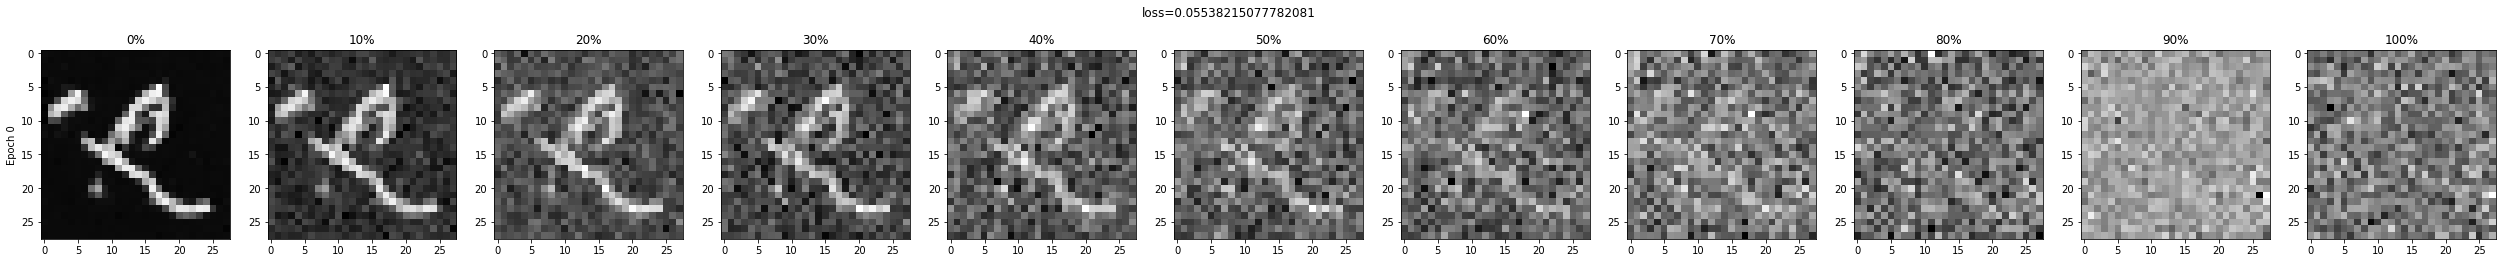

 10%|████████▍                                                                           | 10/100 [00:28<03:59,  2.66s/it]

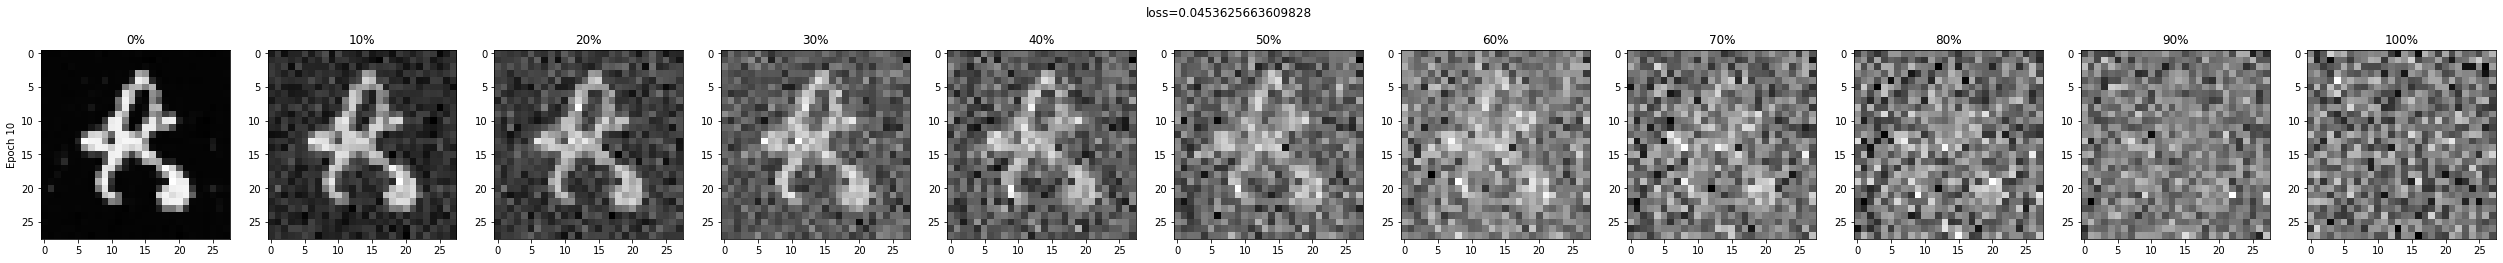

 20%|████████████████▊                                                                   | 20/100 [00:55<03:33,  2.67s/it]

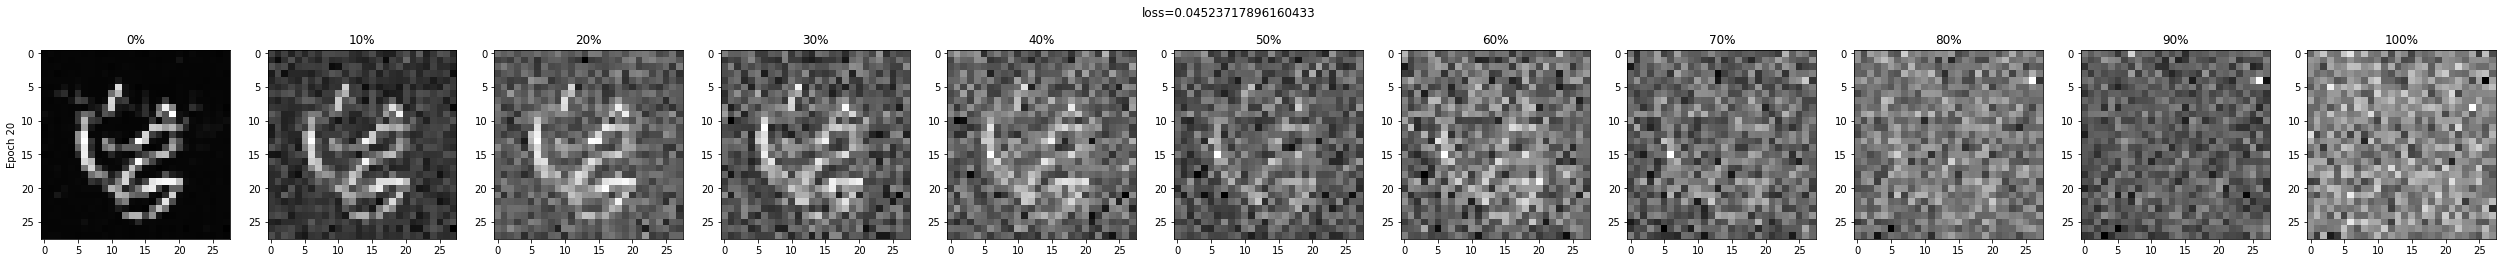

 30%|█████████████████████████▏                                                          | 30/100 [01:24<03:08,  2.70s/it]

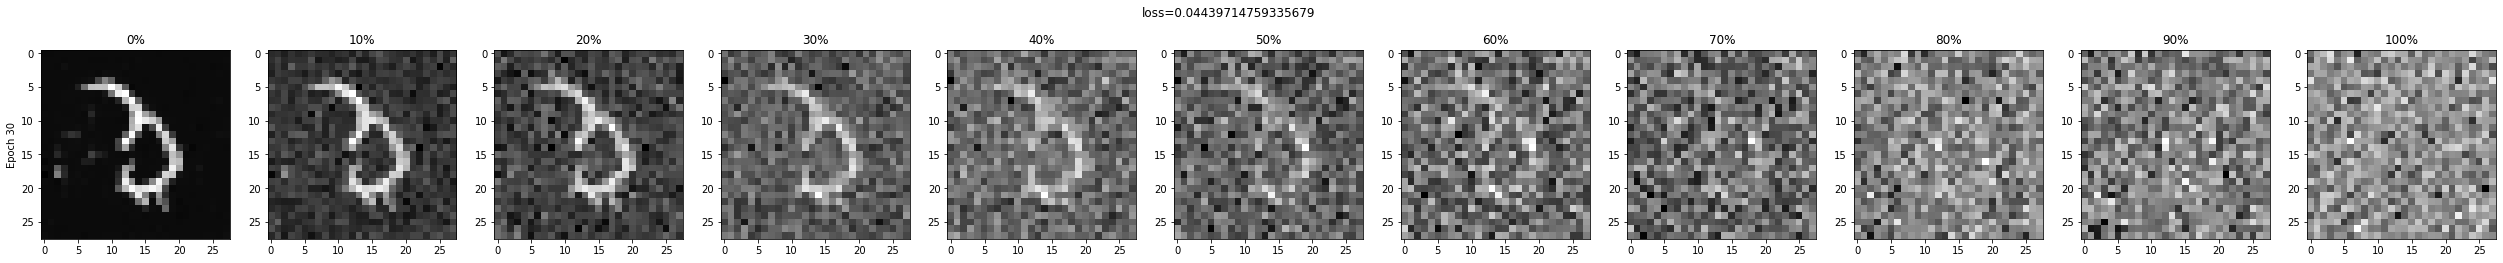

 40%|█████████████████████████████████▌                                                  | 40/100 [01:52<02:46,  2.77s/it]

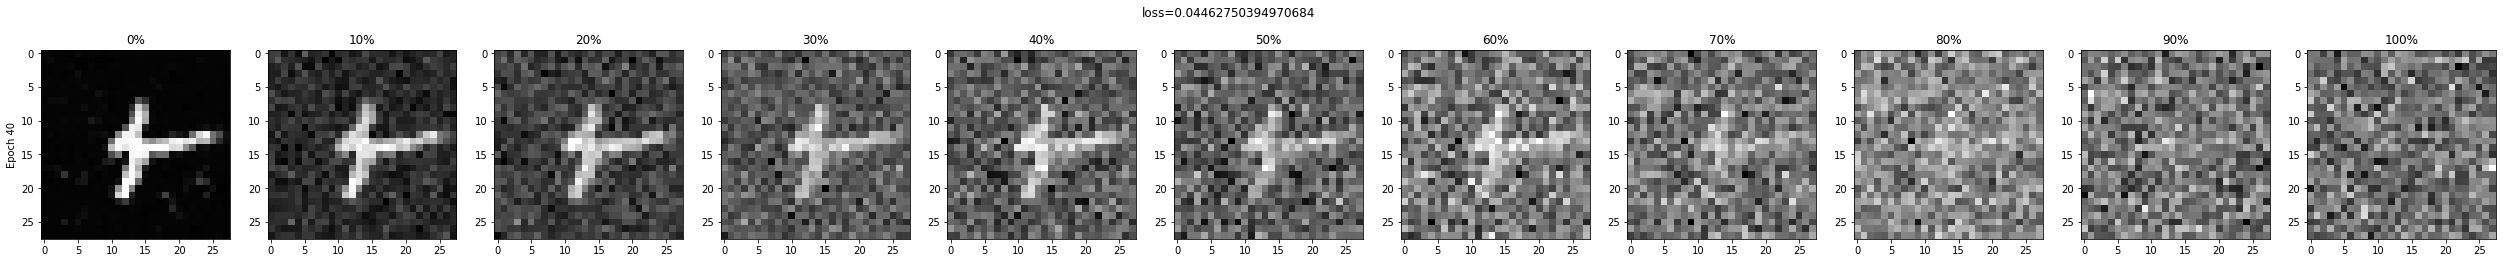

 50%|██████████████████████████████████████████                                          | 50/100 [02:20<02:14,  2.69s/it]

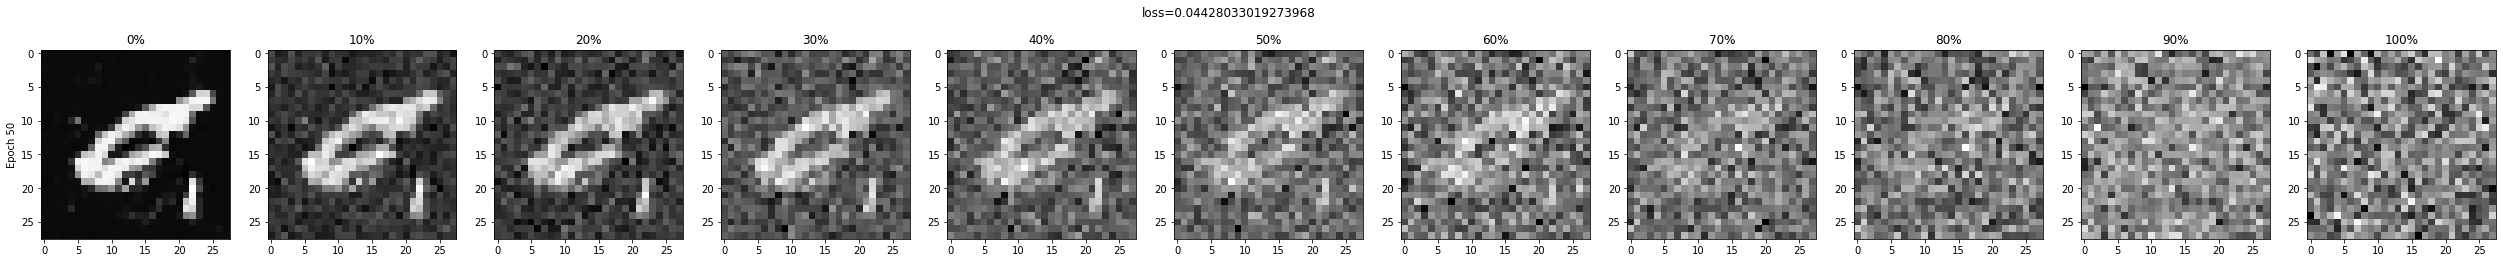

 60%|██████████████████████████████████████████████████▍                                 | 60/100 [02:48<01:51,  2.78s/it]

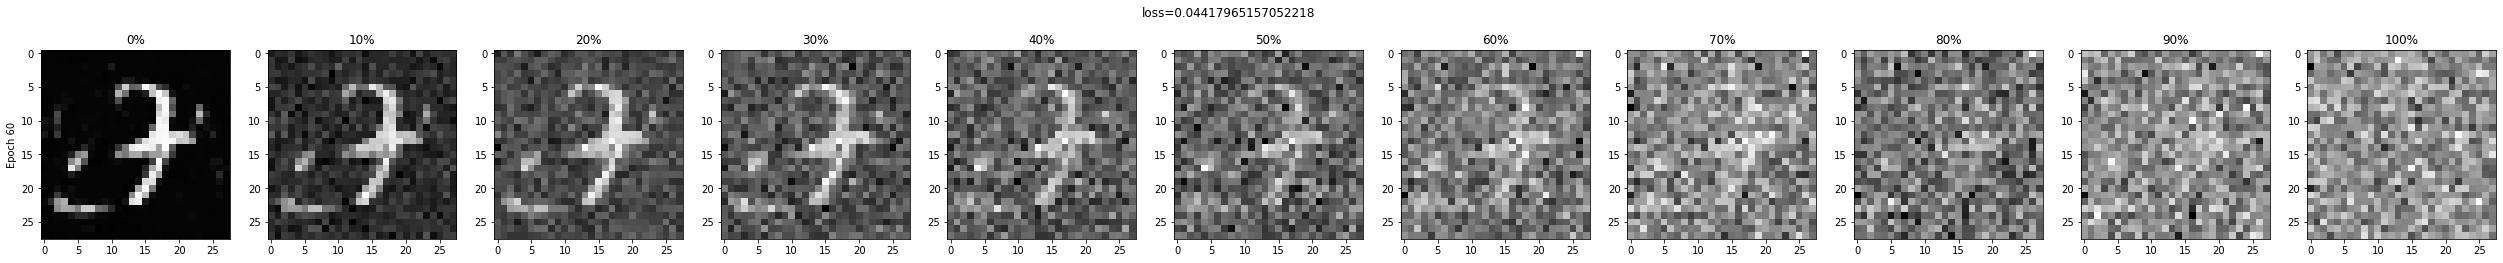

 70%|██████████████████████████████████████████████████████████▊                         | 70/100 [03:16<01:20,  2.69s/it]

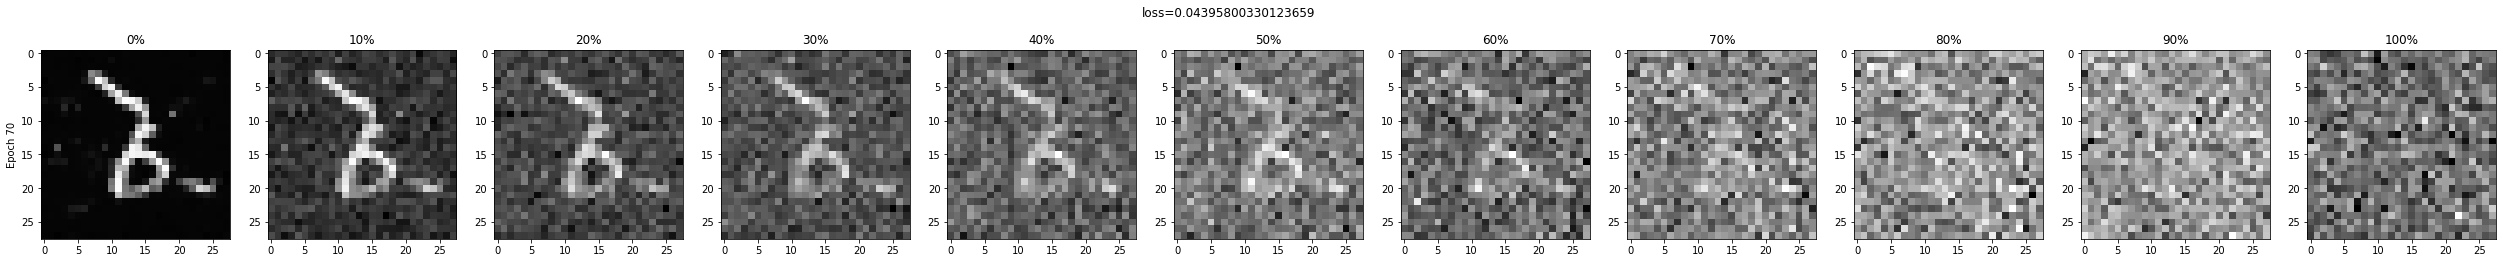

 80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [03:45<00:55,  2.77s/it]

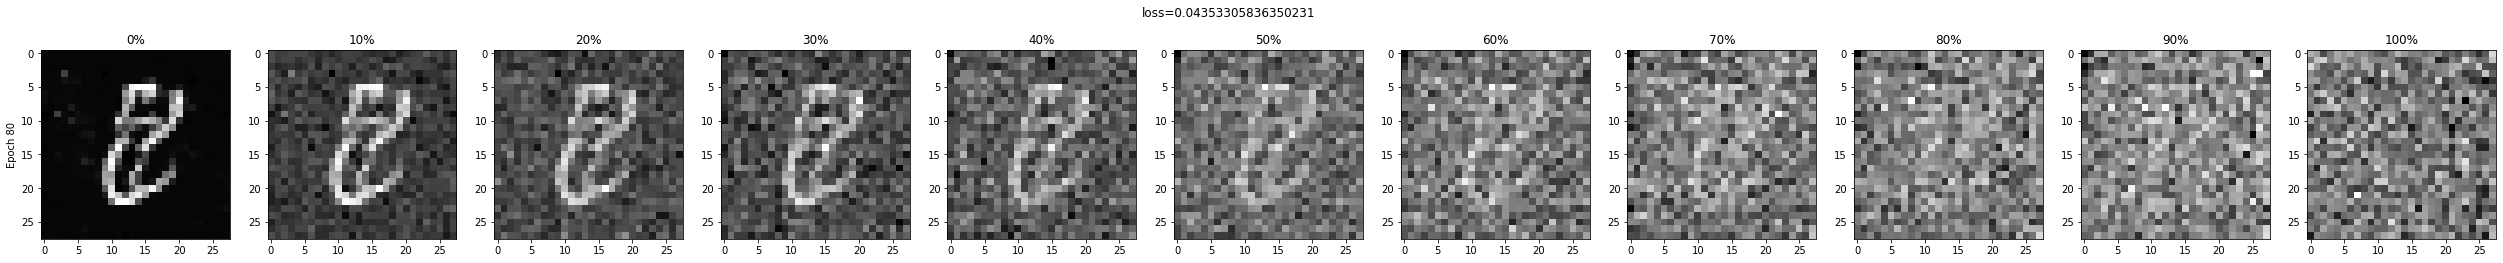

 90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [04:13<00:27,  2.71s/it]

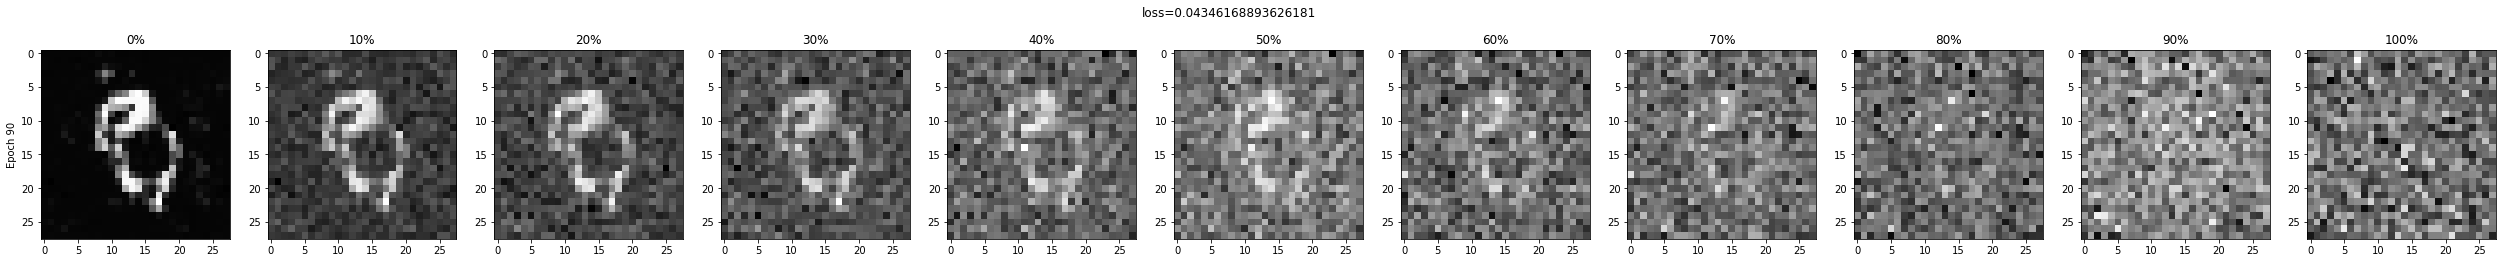

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.82s/it]


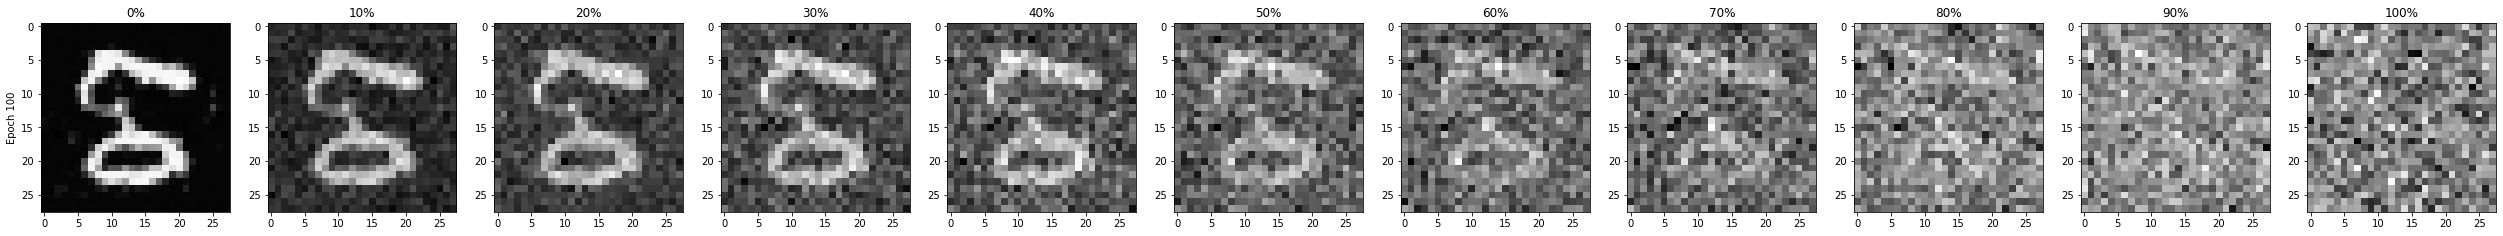

In [55]:
BATCH_SIZE = 1024
NB_EPOCHS = 100

def display_evolutions(epoch, losses=[]):
    if losses:
        loss = sum(losses) / len(losses)
    xs_t = backward_module.loop_backward(n_sample=1, nb_displayed_steps=NB_DISPLAYED)
    x_t = rearrange(xs_t, "t 1 h w -> t h w")
    plot_evolutions(x_t, title=f"loss={loss}" if losses else None, y_title=f"Epoch {epoch}")

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
noise_model.fit(dataloader, nb_epochs=NB_EPOCHS, logger=display_evolutions)
display_evolutions(NB_EPOCHS)

## Backward

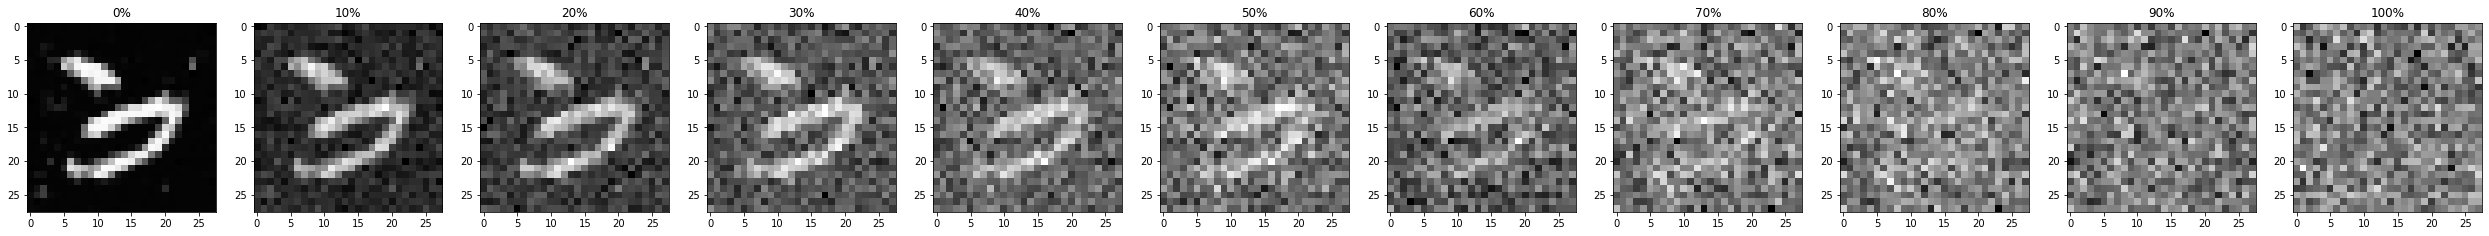

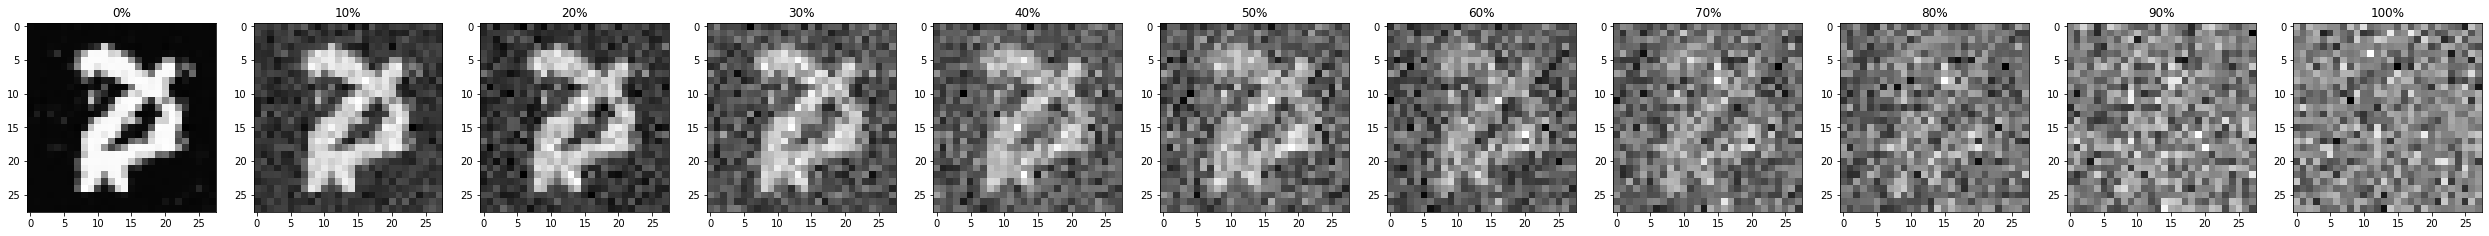

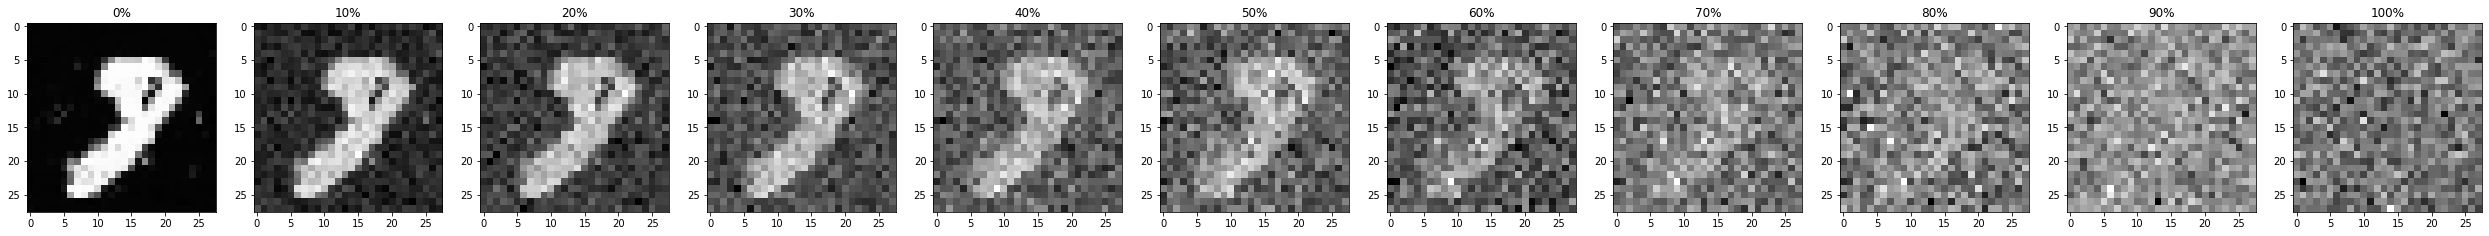

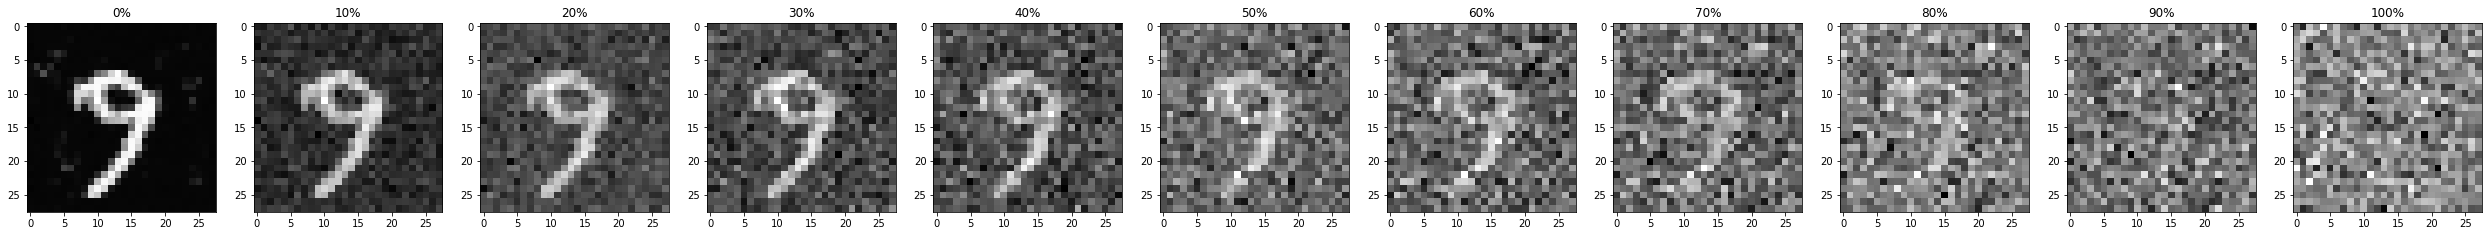

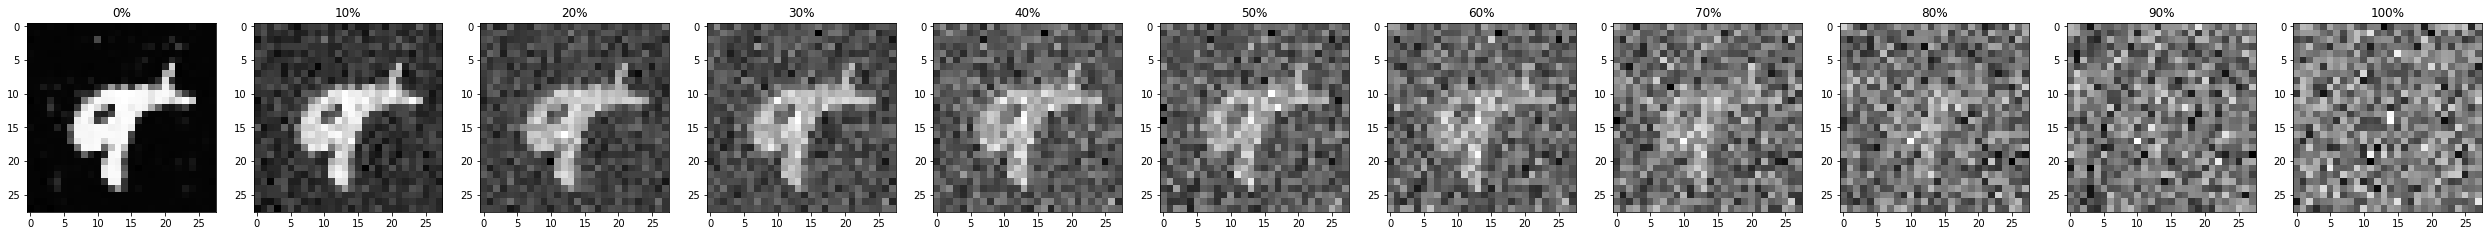

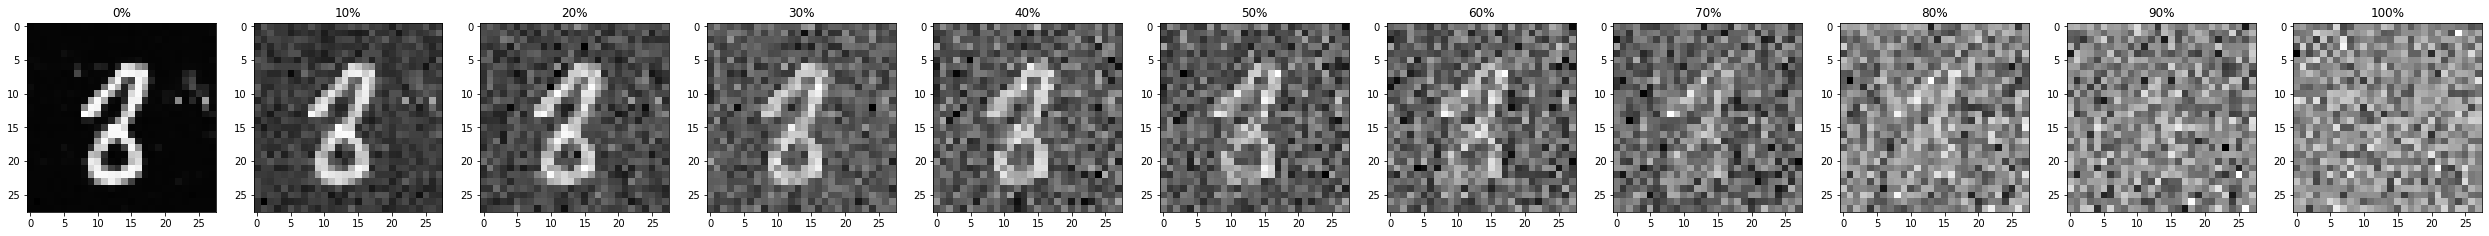

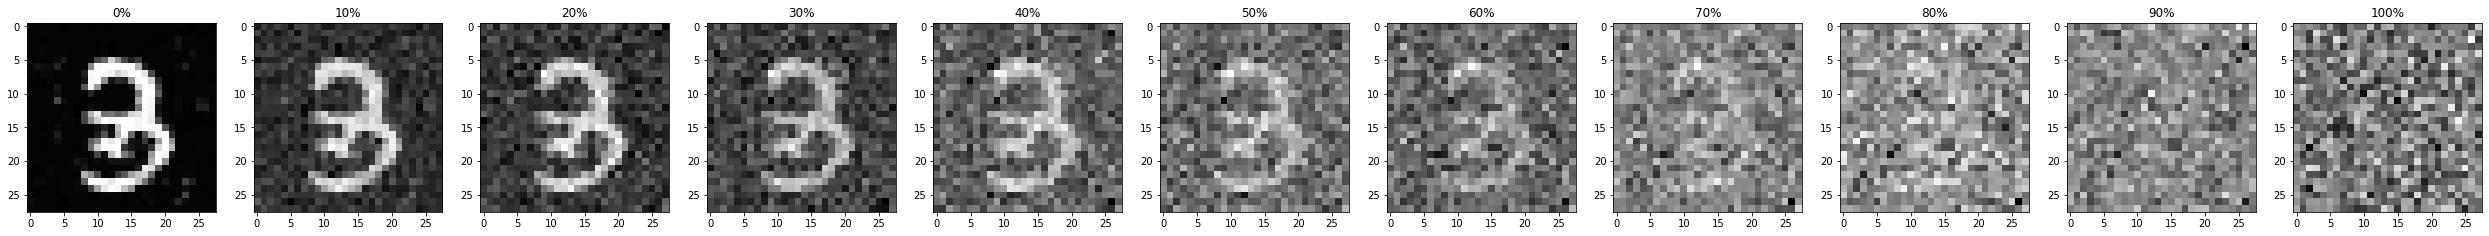

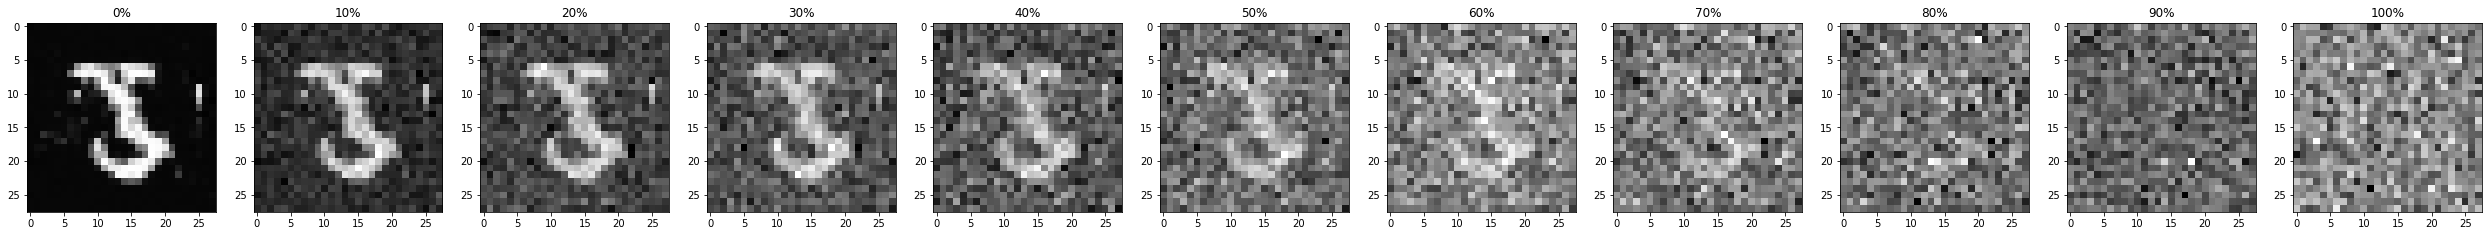

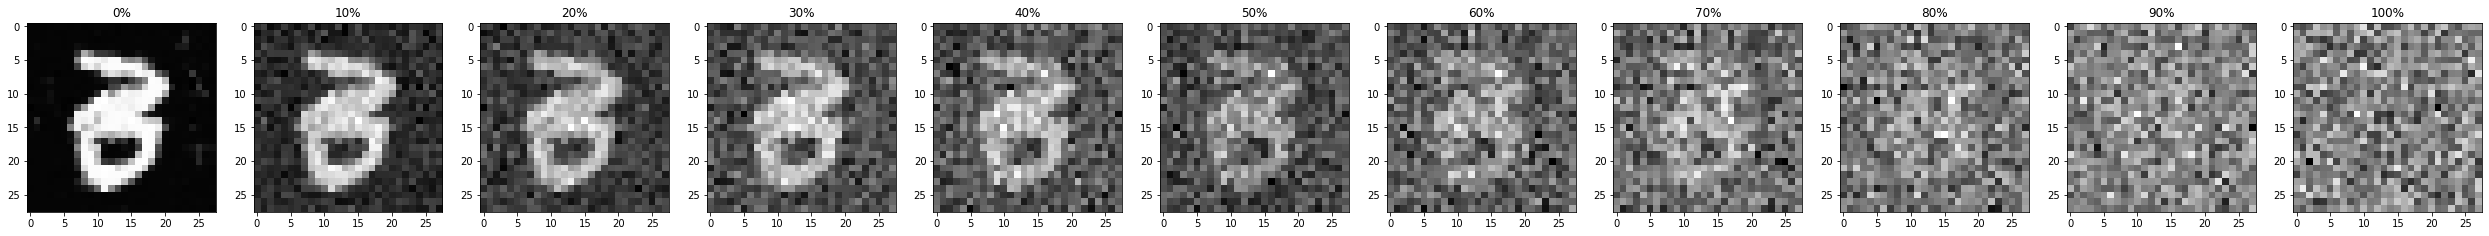

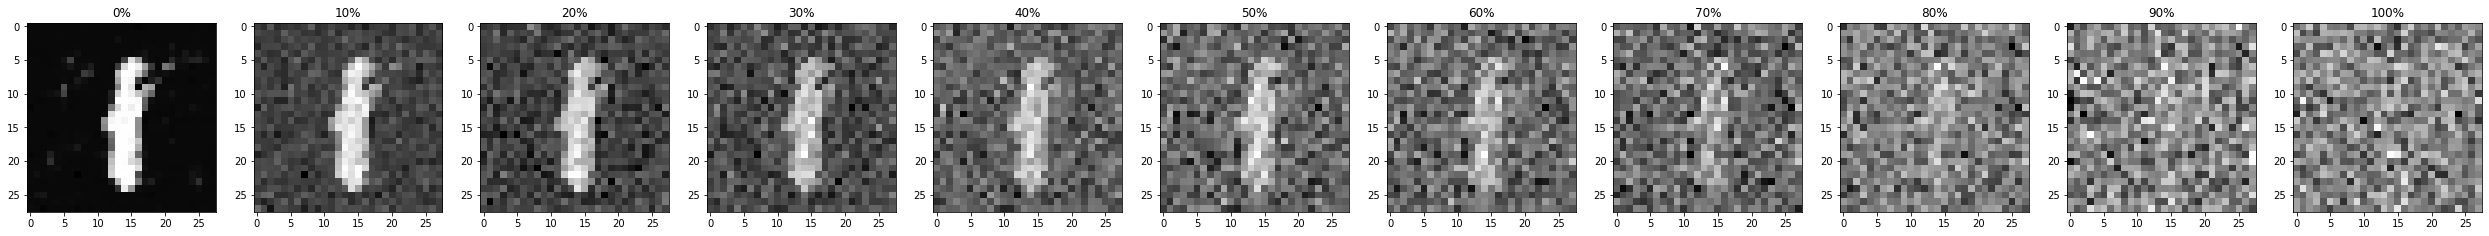

In [56]:
NB_EXAMPLES = 10

xs = backward_module.loop_backward(n_sample=NB_EXAMPLES, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for x in xs:
    plot_evolutions(x)